In [1]:
import unittest
import os
import io
from inverter_simulator.simulator import InverterSimulator
from aemo_to_tariff import spot_to_tariff
import json
from zoneinfo import ZoneInfo
import requests
import pandas as pd
from datetime import datetime, timedelta
from requests.models import PreparedRequest


In [2]:

API_KEY = os.getenv('POWSTON_API_KEY')

powston_test_server = os.getenv("POWSTON_TEST_SERVER", 'https://dev.inverterintelligence.com')
header = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}
site_id = 90

url = f'{powston_test_server}/api/meter_data/{site_id}'
params = {
    "from_date": "2024-12-15",
    "to_date": "2024-12-19"}
req = PreparedRequest()
req.prepare_url(url, params)

response = requests.get(req.url, headers=header).json()

meter_data_df = pd.read_json(response, orient="records", convert_dates=['interval_time'])
meter_data_df['interval_time'] = pd.to_datetime(meter_data_df['interval_time']).dt.tz_convert(ZoneInfo("Australia/Brisbane"))
meter_data_df.set_index('interval_time', inplace=True)
meter_data_df.sort_index(inplace=True)
# remove duplcates and keep the last value
meter_data_df = meter_data_df[~meter_data_df.index.duplicated(keep='last')]
meter_data_df

/tmp/ipykernel_1840424/2583927956.py:19: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  meter_data_df = pd.read_json(response, orient="records", convert_dates=['interval_time'])


,energy_import,energy_export,battery_w,rrp,hhf_rrp,forecasts,solar_power,house_power,billed_costs,billed_earnings,buy_price,sell_price
interval_time,,,,,,,,,,,,
2024-12-14 23:00:00+10:00,0.001167,0.000833,NaN,208.00,208.00,"[188.75, 247.68, 220.0, 186.14, 149.98, 146.05...",NaN,NaN,0.583694,0.018446,29.533634,20.800
2024-12-14 23:05:00+10:00,0.000833,0.000833,NaN,262.71,262.71,"[188.75, 247.68, 220.0, 186.14, 149.98, 146.05...",NaN,NaN,0.576559,0.023298,35.507528,26.271
2024-12-14 23:10:00+10:00,0.000833,0.000833,NaN,250.68,250.68,"[205.51, 190.68, 209.43, 185.41, 149.98, 146.0...",NaN,NaN,0.575385,0.022231,34.193948,25.068
2024-12-14 23:15:00+10:00,0.000833,0.000833,NaN,258.69,258.69,"[205.51, 190.68, 209.43, 185.41, 149.98, 146.0...",NaN,NaN,0.576167,0.022942,35.068576,25.869
2024-12-14 23:20:00+10:00,0.000833,0.000833,NaN,215.85,215.85,"[205.51, 190.68, 209.43, 185.41, 149.98, 146.0...",NaN,NaN,0.571988,0.019142,30.390791,21.585
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-18 22:35:00+10:00,0.001667,0.001500,NaN,85.46,85.46,"[100.51, 72.1, 77.36, 76.72, 76.0, 76.0, 69.53...",NaN,NaN,0.578492,0.013642,16.153248,8.546
2024-12-18 22:40:00+10:00,0.001667,0.001500,NaN,87.50,87.50,"[79.6, 74.85, 75.88, 83.4, 76.72, 76.72, 76.0,...",NaN,NaN,0.578891,0.013968,16.375999,8.750
2024-12-18 22:45:00+10:00,0.001667,0.001500,NaN,84.51,84.51,"[79.6, 74.85, 75.88, 83.4, 76.72, 76.72, 76.0,...",NaN,NaN,0.578307,0.013490,16.049515,8.451


,energy_import,energy_export,battery_w,rrp,hhf_rrp,forecasts,solar_power,house_power,billed_costs,billed_earnings,buy_price,sell_price
interval_time,,,,,,,,,,,,
2024-12-14 23:00:00+10:00,0.001167,0.000833,NaN,208.00,208.00,"[188.75, 247.68, 220.0, 186.14, 149.98, 146.05...",NaN,NaN,0.583694,0.018446,29.533634,20.800
2024-12-14 23:05:00+10:00,0.000833,0.000833,NaN,262.71,262.71,"[188.75, 247.68, 220.0, 186.14, 149.98, 146.05...",NaN,NaN,0.576559,0.023298,35.507528,26.271
2024-12-14 23:10:00+10:00,0.000833,0.000833,NaN,250.68,250.68,"[205.51, 190.68, 209.43, 185.41, 149.98, 146.0...",NaN,NaN,0.575385,0.022231,34.193948,25.068
2024-12-14 23:15:00+10:00,0.000833,0.000833,NaN,258.69,258.69,"[205.51, 190.68, 209.43, 185.41, 149.98, 146.0...",NaN,NaN,0.576167,0.022942,35.068576,25.869
2024-12-14 23:20:00+10:00,0.000833,0.000833,NaN,215.85,215.85,"[205.51, 190.68, 209.43, 185.41, 149.98, 146.0...",NaN,NaN,0.571988,0.019142,30.390791,21.585
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-18 22:35:00+10:00,0.001667,0.001500,NaN,85.46,85.46,"[100.51, 72.1, 77.36, 76.72, 76.0, 76.0, 69.53...",NaN,NaN,0.578492,0.013642,16.153248,8.546
2024-12-18 22:40:00+10:00,0.001667,0.001500,NaN,87.50,87.50,"[79.6, 74.85, 75.88, 83.4, 76.72, 76.72, 76.0,...",NaN,NaN,0.578891,0.013968,16.375999,8.750
2024-12-18 22:45:00+10:00,0.001667,0.001500,NaN,84.51,84.51,"[79.6, 74.85, 75.88, 83.4, 76.72, 76.72, 76.0,...",NaN,NaN,0.578307,0.013490,16.049515,8.451


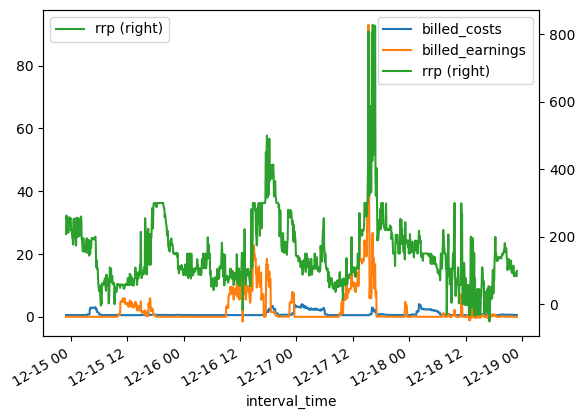

In [3]:
plt = meter_data_df[['billed_costs', 'billed_earnings']].plot(legend=True)
plt.legend(loc='upper left')
plt = meter_data_df['rrp'].plot(secondary_y=True, ax=plt, legend=True)
plt.legend(loc='upper left')
meter_data_df

In [4]:
from matplotlib import pyplot as plt

def plot():
    ret_df['cost'] = ret_df['sim_cost']
    title = 'Simulation run'
    max_zoomed_rrp = 500

    if 'house_power' in ret_df.columns:
        ret_df['house_consumption'] = ret_df['house_power']
    if 'solar_power' in ret_df.columns:
        ret_df['ppv'] = ret_df['solar_power']
    if 'as_is_grid' not in ret_df.columns:
        if 'pgrid' in ret_df.columns:
            ret_df['as_is_grid'] = ret_df['pgrid']
        elif 'house_consumption' in ret_df.columns and 'ppv' in ret_df.columns:
            ret_df['as_is_grid'] = ret_df['house_consumption'] - ret_df['ppv']
        else:
            ret_df['as_is_grid'] = ret_df['Power from grid'] - ret_df['Power to grid']
    # Negative draws from the grid (so get absolute value)
    ret_df['as_is_general_power'] = abs(ret_df['as_is_grid'].clip(upper=0))
    if 'as_is_general_kwh' not in ret_df.columns:
        ret_df['as_is_general_kwh'] = ret_df['as_is_general_power'] / 1000.0 * 5 / 60
    # Positive draws from the grid
    ret_df['as_is_feed_in_power'] = ret_df['as_is_grid'].clip(lower=0)
    if 'as_is_feed_in_kwh' not in ret_df.columns:
        ret_df['as_is_feed_in_kwh'] = ret_df['as_is_feed_in_power'] / 1000.0 * 5 / 60

    nb_bill = 0
    retail_bill = ret_df['cost'].sum() / 100
    # five plots one ontop of the other, the first one twice as high as the others
    fig, ax = plt.subplots(5, 1, figsize=(20, 15), sharex=True)
    ax[0].grid()
    # First show costs
    start_date, end_date = ret_df.index[0], ret_df.index[-1]
    ax[0].set_title(f'{title}: {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}')

    algo_label = 'Algo cost (Wholesale + Battery Management) $%.2f' % retail_bill
    ax[0].plot(ret_df['cost'].cumsum(), label=algo_label, color='orange')
    if 'billed_costs' in ret_df.columns and 'billed_earnings' in ret_df.columns:
        ret_df['retail_cost'] = (ret_df['billed_costs'] - ret_df['billed_earnings'])
        retail_label = 'Reported Bill'
        ax[0].plot(ret_df['retail_cost'].cumsum(), label='%s $%.2f' % (retail_label, ret_df['retail_cost'].sum() / 100), color='red')
        ax[0].legend()
    ax[0].xaxis.set_visible(False)
    ax[0].legend()
    # Set height of ax[0] to twice the height of ax[1]
    box = ax[0].get_position()
    ax[0].set_position([box.x0, box.y0, box.width, box.height * 1.5])

    # show as bar chart Power to grid	Power from grid
    ax[1].grid()
    ax[1].set_title('Power to and from grid')
    ax[1].plot(ret_df.index, ret_df['Power from grid'], label='Power from grid (W)')
    ax[1].plot(ret_df.index, -ret_df['Power to grid'], label='Power to grid (W)')

    if 'general_kwh' in ret_df.columns and 'feed_in_kwh' in ret_df.columns:
        kwh_to_w = 1000 * 60 / interval
        ax[1].plot(ret_df.index, ret_df['general_kwh'] * kwh_to_w, label='Metered general (W)')
        ax[1].plot(ret_df.index, -ret_df['feed_in_kwh'] * kwh_to_w, label='Metered feed (W)')

    ax[1].legend()
    ax[1].xaxis.set_visible(False)
    # now SOC and actions
    ax[2].xaxis.set_visible(False)
    ax[2].grid()
    if 'battery_charge' in ret_df.columns:
        ax[2].set_title('Battery charge')
        ax[2].plot(ret_df['battery_charge'], label='Battery charge (Wh)', color='green')
        ax[2].legend()
    elif 'battery_soc' in ret_df.columns:
        ax[2].set_title('Battery SOC')
        ax[2].plot(ret_df['battery_soc'], label='Battery SOC (%)', color='green')
        ax[2].legend()
    if 'battery_actual' in ret_df.columns:
        ax[2].plot(ret_df['battery_actual'], label='Battery actual (Wh)', color='blue')
        ax[2].legend()
    if 'action' in ret_df.columns:
        ax[2].set_title('Battery charge with actions')
        ret_df['change_action'] = ret_df['action'].shift(1) != ret_df['action']
        for row in ret_df[ret_df['change_action']].iterrows():
            if row[1]['action'] == 'export':
                color = 'red'
            elif row[1]['action'] == 'import':
                color = 'green'
            elif row[1]['action'] == 'charge':
                color = 'blue'
            elif row[1]['action'] == 'auto':
                color = 'grey'
            elif row[1]['action'] == 'discharge':
                color = 'purple'
            else:
                color = 'black'
            ax[2].text(row[0], row[1]['battery_charge'], f"{row[1]['action'][0]}", color=color)
    ax[3].set_title('House consumption vs Solar Generation')
    ax[3].plot(ret_df['house_consumption'], label='House consumption (W)', color='blue')
    ax[3].plot(ret_df['ppv'], color='orange', label="Solar output (W)")
    ax[3].legend()
    ax[3].grid()
    ax[3].xaxis.set_visible(False)

    # then subplot show rrp but only scale to 300
    if ret_df['rrp'].max() > 1000:
        ax[4].set_ylim(-10, max_zoomed_rrp)
    ax[4].grid()
    ax[4].set_title('Wholesale market price')
    ax[4].plot(ret_df['rrp']/10, label='Spot price c/kWh', color='darkgreen')
    if 'general_tariff' in ret_df.columns:
        ax[4].plot(ret_df['general_tariff'], label='General price c/kWh', color='darkblue')
    ax[4].legend()

In [5]:
response = requests.get(f'{powston_test_server}/api/site/{site_id}', headers=header).json()
network = response['network']
tariff = response['tariff']
installed_solar = response['installed_solar']
installed_battery = response['installed_battery']
inverter_power = response['inverter_power']
timezone = response['timezone']
latitude = response['latitude']
longitude = response['longitude']

User code 0.0 v auto only 0.0


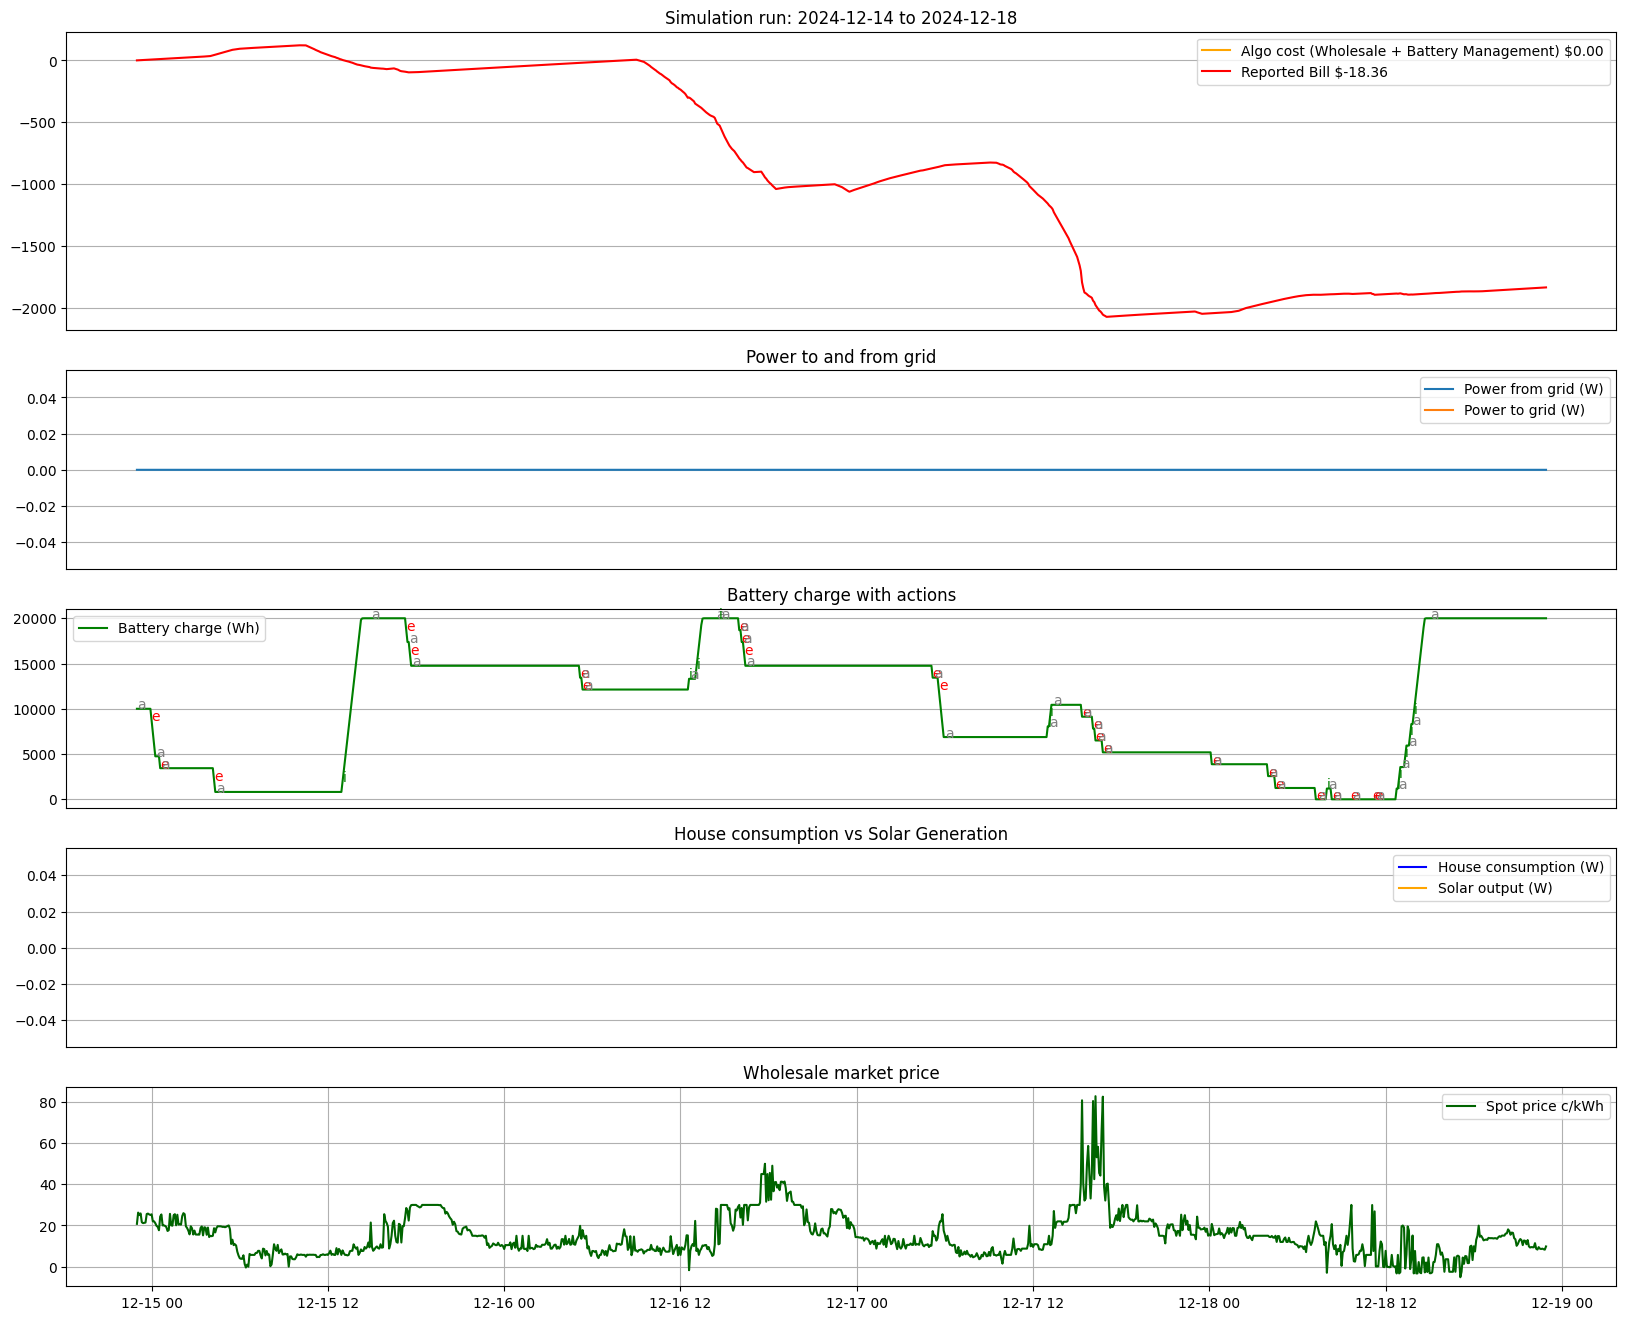

In [6]:
from astral import LocationInfo
from astral.sun import sun

filename = "nsw_script.py"
try:
    with open(filename, "r") as file:
        content = file.read()
except FileNotFoundError:
    print(f"R001 File {filename} not found")

def always_auto(inverter_time, **kwargs):
    return 'auto', 'always_auto'
    
battery_capacity = installed_battery
charge_rate = inverter_power
max_ppv_power = installed_solar
meter_data_df['forecast'] = meter_data_df['forecasts']
sim = InverterSimulator(meter_data_df.copy(), always_auto, battery_capacity=battery_capacity,
                        spot_to_tariff=spot_to_tariff, tariff=tariff, network=network,
                        charge_rate=charge_rate, max_ppv_power=max_ppv_power)
auto_bill, ret_df = sim.run_simulation()

def run_user_code(interval_time, **kwargs):
    params = {'interval_time': interval_time,
              'battery_capacity': battery_capacity,
              'charge_rate': charge_rate,
              'max_ppv_power': max_ppv_power,
              'action': 'auto',
              'reason': 'default: auto',
              'location': LocationInfo("Brisbane", "Australia", timezone, latitude, longitude)}
    for key, val in kwargs.items():
        params[key] = val
    with open(filename, "r") as file:
        content = file.read()
        code = compile(content, filename, 'exec')
        eval(code, globals(), params)
    return params['action'], params['reason']

sim = InverterSimulator(meter_data_df.copy(), run_user_code, battery_capacity=battery_capacity,
                        spot_to_tariff=spot_to_tariff, tariff=tariff, network=network,
                        charge_rate=charge_rate, max_ppv_power=max_ppv_power)
sim_bill, ret_df = sim.run_simulation()

print('User code', round(sim_bill/100, 2), 'v auto only', round(auto_bill/100, 2))
plot()